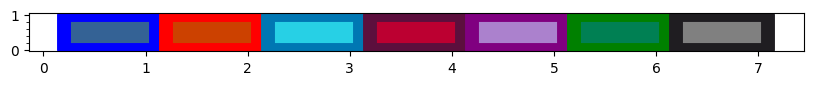

In [31]:
import json

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as ptchs
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.optimize
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from pandas.core.base import PandasObject
from sklearn.linear_model import Ridge

cpu_system = "l4"
cpu_vd_input_folder = f"../cpu-sequential/{cpu_system}-cpu/"
cpu_mb_input_folder = f"../microbenchmarks/{cpu_system}/"
cpu_output_folder = f"../../images/{cpu_system}"
%run ../notebook_setup.ipynb

# Data

## Inner validation

In [32]:
inner_cpu_validation_results = f"{cpu_vd_input_folder}/inner_validation"
inner_cpu_validation_df = pd.read_csv(inner_cpu_validation_results)
inner_cpu_validation_df["nvals"] = inner_cpu_validation_df["input"].apply(
    lambda s: float(s.split("_")[-1].split(".")[0])
)
inner_cpu_validation_df["distribution"] = inner_cpu_validation_df["input"].apply(
    lambda s: s.split("_")[1]
)
convert_to_type(inner_cpu_validation_df, "tfindbin", np.float64)
convert_to_type(inner_cpu_validation_df, "tfill", np.float64)
convert_to_type(inner_cpu_validation_df, "tstats", np.float64)
convert_to_type(inner_cpu_validation_df, "edges", np.bool_)
del inner_cpu_validation_df["input"]
inner_cpu_validation_df

,iter,env,nthreads,nbins,bulksize,edges,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CPU,1,10,1,False,1.124825,0.893294,0.894799,6.476572,5.000000e+07,uniform
1,0,CPU,1,10,1,False,2.247089,1.786975,1.788669,12.651636,1.000000e+08,uniform
2,0,CPU,1,10,1,False,11.237829,8.925306,8.936201,64.012907,5.000000e+08,uniform
3,0,CPU,1,10,1,False,22.466257,17.943364,17.877347,126.320811,1.000000e+09,uniform
4,0,CPU,1,10,1,False,1.124287,0.893088,0.894574,6.464808,5.000000e+07,constant-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
4475,4,CPU,1,10000000,262144,True,242.211155,102.339769,18.022694,393.747302,1.000000e+09,normal-0.4-0.1
4476,4,CPU,1,10000000,262144,True,8.173643,4.707604,0.901068,15.526217,5.000000e+07,normal-0.7-0.01
4477,4,CPU,1,10000000,262144,True,16.474228,9.478578,1.801463,31.083019,1.000000e+08,normal-0.7-0.01
4478,4,CPU,1,10000000,262144,True,82.531702,48.326642,8.997447,155.805720,5.000000e+08,normal-0.7-0.01


## Total validation

In [3]:
cpu_validation_results = f"{cpu_vd_input_folder}/validation"
cpu_validation_df = pd.read_csv(cpu_validation_results)
cpu_validation_df["nvals"] = cpu_validation_df["input"].apply(
    lambda s: float(s.split("_")[-1].split(".")[0])
)
cpu_validation_df["distribution"] = cpu_validation_df["input"].apply(
    lambda s: s.split("_")[1]
)
convert_to_type(cpu_validation_df, "tfindbin", np.float64)
convert_to_type(cpu_validation_df, "tfill", np.float64)
convert_to_type(cpu_validation_df, "tstats", np.float64)
convert_to_type(cpu_validation_df, "edges", np.bool_)
del cpu_validation_df["input"]
cpu_validation_df

,iter,env,nthreads,nbins,bulksize,edges,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CPU,1,10,1,False,0.0,0.0,0.0,2.641837,5.000000e+07,uniform
1,0,CPU,1,10,1,False,0.0,0.0,0.0,5.306042,1.000000e+08,uniform
2,0,CPU,1,10,1,False,0.0,0.0,0.0,26.743646,5.000000e+08,uniform
3,0,CPU,1,10,1,False,0.0,0.0,0.0,52.471924,1.000000e+09,uniform
4,0,CPU,1,10,1,False,0.0,0.0,0.0,2.691372,5.000000e+07,constant-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
9595,4,CPU,1,10000000,134217728,True,0.0,0.0,0.0,219.744214,1.000000e+09,normal-0.4-0.1
9596,4,CPU,1,10000000,134217728,True,0.0,0.0,0.0,7.523234,5.000000e+07,normal-0.7-0.01
9597,4,CPU,1,10000000,134217728,True,0.0,0.0,0.0,15.083827,1.000000e+08,normal-0.7-0.01
9598,4,CPU,1,10000000,134217728,True,0.0,0.0,0.0,74.759029,5.000000e+08,normal-0.7-0.01


In [4]:
cpu_gp_ivd = inner_cpu_validation_df.groupby(
    ["env", "distribution", "nvals", "nbins", "bulksize", "edges"]
)
cpu_gp_ivd.mean()

iter  nthreads  \
env distribution nvals        nbins    bulksize edges                   
CPU constant-0.5 5.000000e+07 10       1        False   2.0       1.0   
                                                True    2.0       1.0   
                                       8        False   2.0       1.0   
                                                True    2.0       1.0   
                                       64       False   2.0       1.0   
...                                                     ...       ...   
    uniform      1.000000e+09 10000000 4096     True    2.0       1.0   
                                       32768    False   2.0       1.0   
                                                True    2.0       1.0   
                                       262144   False   2.0       1.0   
                                                True    2.0       1.0   

                                                         tfindbin       tfill  \
env distribution nvals        nbins    bulksize edges                           
CPU constant-0.5 5.000000e+07 10       1        False    1.126646    0.896117   
                                                True     1.087089    0.896845   
                                       8        False    1.125458    0.898147   
                                                True     1.082175    0.896905   
                                       64       False    1.124613    0.895263   
...                                                           ...         ...   
    uniform      1.000000e+09 10000000 4096     True   338.787680  116.219527   
                                       32768    False   22.437615   86.989115   
                                                True   338.550014  116.366693   
                                       262144   False   22.496526   89.717988   
                                                True   342.948709  115.562429   

                                                          tstats      ttotal  
env distribution nvals        nbins    bulksize edges                         
CPU constant-0.5 5.000000e+07 10       1        False   0.895057    6.377287  
                                                True    0.901000    6.354033  
                                       8        False   0.896925    4.973906  
                                                True    0.896544    4.906309  
                                       64       False   0.896806    4.445563  
...                                                          ...         ...  
    uniform      1.000000e+09 10000000 4096     True   18.015208  503.959836  
                                       32768    False  17.937313  157.202161  
                                                True   18.085168  504.027525  
                                       262144   False  17.944395  160.451088  
                                                True   18.035403  507.660155  

[896 rows x 6 columns]

In [5]:
cpu_gp_vd = cpu_validation_df.groupby(
    ["env", "distribution", "nvals", "nbins", "bulksize", "edges"]
)
cpu_gp_vd.mean()

iter  nthreads  \
env distribution nvals        nbins    bulksize  edges                   
CPU constant-0.5 5.000000e+07 10       1         False   2.0       1.0   
                                                 True    2.0       1.0   
                                       8         False   2.0       1.0   
                                                 True    2.0       1.0   
                                       64        False   2.0       1.0   
...                                                      ...       ...   
    uniform      1.000000e+09 10000000 2097152   True    2.0       1.0   
                                       16777216  False   2.0       1.0   
                                                 True    2.0       1.0   
                                       134217728 False   2.0       1.0   
                                                 True    2.0       1.0   

                                                        tfindbin  tfill  \
env distribution nvals        nbins    bulksize  edges                    
CPU constant-0.5 5.000000e+07 10       1         False       0.0    0.0   
                                                 True        0.0    0.0   
                                       8         False       0.0    0.0   
                                                 True        0.0    0.0   
                                       64        False       0.0    0.0   
...                                                          ...    ...   
    uniform      1.000000e+09 10000000 2097152   True        0.0    0.0   
                                       16777216  False       0.0    0.0   
                                                 True        0.0    0.0   
                                       134217728 False       0.0    0.0   
                                                 True        0.0    0.0   

                                                        tstats      ttotal  
env distribution nvals        nbins    bulksize  edges                      
CPU constant-0.5 5.000000e+07 10       1         False     0.0    2.624595  
                                                 True      0.0    2.730199  
                                       8         False     0.0    1.017658  
                                                 True      0.0    1.140870  
                                       64        False     0.0    0.566720  
...                                                        ...         ...  
    uniform      1.000000e+09 10000000 2097152   True      0.0  274.632616  
                                       16777216  False     0.0   32.632601  
                                                 True      0.0  278.588129  
                                       134217728 False     0.0   35.693131  
                                                 True      0.0  277.906917  

[1792 rows x 6 columns]

In [6]:
unique_nbins = cpu_validation_df["nbins"].unique().astype(np.float64)
unique_nvals = cpu_validation_df["nvals"].unique().astype(np.float64)
unique_bulksize = cpu_validation_df["bulksize"].unique().astype(np.float64)
unique_distribution = sorted(cpu_validation_df["distribution"].unique())
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize, unique_distribution, unique_edges

(array([1.e+01, 1.e+03, 1.e+05, 1.e+07]),
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array([1.00000000e+00, 8.00000000e+00, 6.40000000e+01, 5.12000000e+02,
        4.09600000e+03, 3.27680000e+04, 2.62144000e+05, 8.19200000e+03,
        1.63840000e+04, 6.55360000e+04, 1.31072000e+05, 2.09715200e+06,
        1.67772160e+07, 1.34217728e+08]),
 ['constant-0.5', 'normal-0.4-0.1', 'normal-0.7-0.01', 'uniform'],
 [True, False])

## LMBench

In [7]:
lmbench_results = f"{cpu_mb_input_folder}/lmbench"
with open(lmbench_results, "r") as f:
    lines = f.readlines()
    latencies = {}
    sizes = {}
    for l in lines:
        if "stride" in l:
            stride = int(l.split("=")[1])
            latencies[stride] = []
            sizes[stride] = []
            continue

        if "." in l:
            latencies[stride].append(float(l.split()[1]))
            sizes[stride].append(
                float(l.split()[0]) * unit_to_unit_factor("mb", "b", bytes=True)
            )

# latencies, sizes

In [8]:
########### LMBench values
T_cpu_l1 = 1.4
T_cpu_l2 = 4
T_cpu_l3 = 24
T_cpu_mem = 80

cpu_l1_size = 49152
cpu_l2_size = 1310720
cpu_l3_size = 37748736

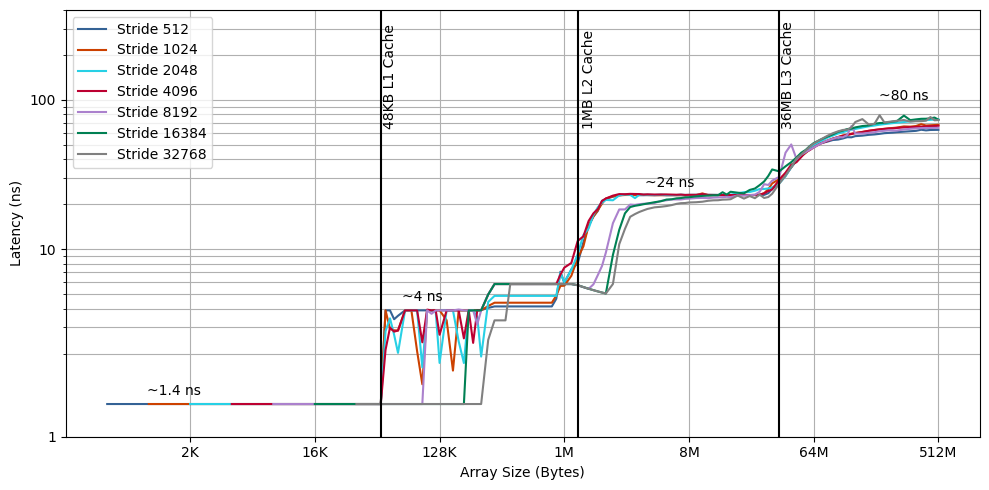

In [9]:
save = True
figname = f"{cpu_output_folder}/lmbench.pdf"
########### LMBench plot ###########
plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
for k, v in sizes.items():
    plt.plot(v, latencies[k], label=f"Stride {k}")

hmax = 400
div = 6
plt.vlines(cpu_l1_size, ymin=0, ymax=hmax, color="k")
plt.text(
    cpu_l1_size + 1500,
    hmax / div,
    f"{human_readable(cpu_l1_size, bytes=True)}B L1 Cache",
    rotation=90,
)
plt.vlines(cpu_l2_size, ymin=0, ymax=hmax, color="k")
plt.text(
    cpu_l2_size + 100500,
    hmax / div,
    f"{human_readable(cpu_l2_size, bytes=True)}B L2 Cache",
    rotation=90,
)
plt.vlines(cpu_l3_size, ymin=0, ymax=hmax, color="k")
plt.text(
    cpu_l3_size + 1000000,
    hmax / div,
    f"{human_readable(cpu_l3_size, bytes=True)}B L3 Cache",
    rotation=90,
)

offset = 0.5
hlx = 0.005
# plt.hlines(1.4, xmin=0, xmax=1e9, color="k")
plt.text(1e3, T_cpu_l1 + 0.1, f"~{T_cpu_l1} ns")
# plt.hlines(4, xmin=0, xmax=1e9, color="gray")
plt.text(70e3, T_cpu_l2 + offset, f"~{T_cpu_l2} ns")
# plt.hlines(24, xmin=0, xmax=1e9, color="gray")
plt.text(4e6, T_cpu_l3 + 2, f"~{T_cpu_l3} ns")
# plt.hlines(80, xmin=0, xmax=1e9, color="gray")
plt.text(200e6, T_cpu_mem + 20, f"~{T_cpu_mem} ns")

plt.legend()

plt.xlabel("Array Size (Bytes)")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)  #
# plt.xlim([0.0005, 32])
# plt.ticklabel_format(axis='x', style='plain')

plt.ylabel("Latency (ns)")
plt.yscale("symlog")
plt.ylim([1, hmax])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
plt.grid(True, which="both")

# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf")
plt.show()

## Microbenchmark Data

In [10]:
filename = f"{cpu_mb_input_folder}/cpu_calibration.json"
# filename = "../das6-cpu-microbenchmark.result"

with open(filename, "r") as f:
    jdata = json.load(f)
cpu_bm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time": float})

convert_to_type(cpu_bm_df, "real_time", np.float64)
cpu_bm_df["func_name"] = cpu_bm_df["name"].apply(lambda s: s.split("/")[0][3:])
del cpu_bm_df["family_index"], cpu_bm_df["per_family_instance_index"]

cpu_bm_df.head(10)

,name,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,bin,nbins,val,aggregate_name,aggregate_unit,dim,func_name
0,BM_BinarySearch/8/0,BM_BinarySearch/8/0,iteration,1000000.0,0.0,1,429,1.635215,1.633970,ms,0.0,1.0,0.0,NaN,NaN,NaN,BinarySearch
1,BM_BinarySearch/8/0,BM_BinarySearch/8/0,iteration,1000000.0,1.0,1,429,1.631299,1.630067,ms,0.0,1.0,0.0,NaN,NaN,NaN,BinarySearch
2,BM_BinarySearch/8/0,BM_BinarySearch/8/0,iteration,1000000.0,2.0,1,429,1.626256,1.624881,ms,0.0,1.0,0.0,NaN,NaN,NaN,BinarySearch
3,BM_BinarySearch/8/0_mean,BM_BinarySearch/8/0,aggregate,1000000.0,NaN,1,3,1.630923,1.629640,ms,0.0,1.0,0.0,mean,time,NaN,BinarySearch
4,BM_BinarySearch/8/0_median,BM_BinarySearch/8/0,aggregate,1000000.0,NaN,1,3,1.631299,1.630067,ms,0.0,1.0,0.0,median,time,NaN,BinarySearch
5,BM_BinarySearch/8/0_stddev,BM_BinarySearch/8/0,aggregate,0.0,NaN,1,3,0.004491,0.004559,ms,0.0,0.0,0.0,stddev,time,NaN,BinarySearch
6,BM_BinarySearch/8/0_cv,BM_BinarySearch/8/0,aggregate,0.0,NaN,1,3,0.002754,0.002798,ms,NaN,0.0,NaN,cv,percentage,NaN,BinarySearch
7,BM_BinarySearch/16/0,BM_BinarySearch/16/0,iteration,1000000.0,0.0,1,231,3.005437,3.003250,ms,0.0,2.0,0.0,NaN,NaN,NaN,BinarySearch
8,BM_BinarySearch/16/0,BM_BinarySearch/16/0,iteration,1000000.0,1.0,1,231,3.019714,3.017523,ms,0.0,2.0,0.0,NaN,NaN,NaN,BinarySearch
9,BM_BinarySearch/16/0,BM_BinarySearch/16/0,iteration,1000000.0,2.0,1,231,3.024682,3.022502,ms,0.0,2.0,0.0,NaN,NaN,NaN,BinarySearch


# Find Bin

## Design

In [11]:
def T_cpu_bscm(cache_size, sub_size, nbins):
    # return (np.log2(sub_size) -
    #         np.log2( cache_size-( np.log2(nbins) - np.log2(sub_size) ) )
    #         + 1).clip(0)
    return (
        np.log2(sub_size)
        - np.log2(cache_size - (np.log2(nbins) / (np.log2(sub_size) + 1)))
        + 1
    ).clip(0)


def T_cpu_binsearch(nbins, subsize):
    return (
        np.log2(nbins) * T_cpu_l1
        + T_cpu_bscm(cpu_l1_size / 8, subsize, nbins) * T_cpu_l2
        + T_cpu_bscm(cpu_l2_size / 8, subsize, nbins) * T_cpu_l3
        + T_cpu_bscm(cpu_l3_size / 8, subsize, nbins) * T_cpu_mem
    )


def T_cpu_findbin(edges, nbins, subsize):
    if edges:
        return T_cpu_binsearch(nbins, subsize)
    else:
        try:
            return np.repeat(T_cpu_fixedsearch, len(nbins))
        except:
            return T_cpu_fixedsearch

## Calibration

In [12]:
fxs_df = cpu_bm_df[cpu_bm_df["func_name"] == "FixedSearch"].copy()
fxs_mean = fxs_df.loc[fxs_df["name"].str.contains("mean")]
fxs_std = fxs_df.loc[fxs_df["name"].str.contains("stddev")]
fxs_mean

,name,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,bin,nbins,val,aggregate_name,aggregate_unit,dim,func_name
913,BM_FixedSearch/manual_time_mean,BM_FixedSearch/manual_time,aggregate,1000000.0,NaN,1,3,16.729587,47.632055,ms,-2.147484e+09,NaN,NaN,mean,time,NaN,FixedSearch


In [13]:
T_cpu_fixedsearch = (
    fxs_mean["real_time"].values[0]
    * unit_to_unit_factor(fxs_mean["time_unit"].values[0], "ns")
    / fxs_mean["repetitions"].values[0]
)
T_cpu_fixedsearch

16.72958687297651

## Validation

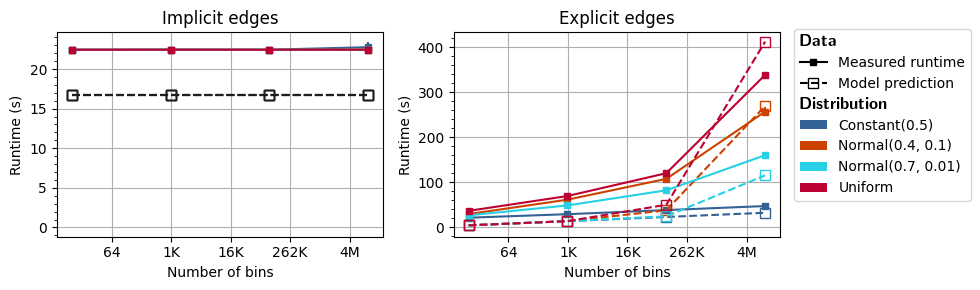

In [14]:
save = True
figname = f"{cpu_output_folder}/cpu_findbin_validation.pdf"
####### nbins vs nvals, distr subplots ###########

selected_env = "CPU"
selected_bulksize = 32768
selected_nvals = 1e9
unit = "s"

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

# Legend Labels
plot_validation_labels()
ax.set_title("Implicit edges")

for di, distr in enumerate(unique_distribution):
    arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, False
    avg = cpu_gp_ivd.mean().loc[arg]
    std = cpu_gp_ivd.std().loc[arg]

    p = ax.errorbar(
        unique_nbins,
        avg["tfindbin"],
        yerr=std["tfindbin"],
        **bm_style,
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    ## prediction
    subsize = get_subsize(distr, unique_nbins)
    pred = (
        T_cpu_findbin(False, unique_nbins, subsize)
        * unit_to_unit_factor("ns", unit)
        * selected_nvals
    )
    ax.errorbar(unique_nbins, pred, c=pred_color, **pred_nocolor_style)


plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Runtime (s)")
yaxis = plt.gca().yaxis
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

##############3
ax = plt.subplot(122)

# Legend Labels
plot_validation_labels()
ax.set_title("Explicit edges")
for di, distr in enumerate(unique_distribution):
    arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, True
    avg = cpu_gp_ivd.mean().loc[arg]
    std = cpu_gp_ivd.std().loc[arg]

    p = ax.errorbar(
        unique_nbins,
        avg["tfindbin"],
        yerr=std["tfindbin"],
        **bm_style,
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    ## prediction
    c = p[0].get_color()
    subsize = get_subsize(distr, unique_nbins)
    pred = (
        T_cpu_findbin(True, unique_nbins, subsize)
        * unit_to_unit_factor("ns", unit)
        * selected_nvals
    )
    ax.errorbar(unique_nbins, pred, c=c, **pred_nocolor_style)

    # observ = avg["tfindbin"].values
    # print(distr, pred, mae(pred, observ), r2(pred, observ) * 100)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

##########
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.6),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

plt.tight_layout()
plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

# Add Bin Content

## Design

In [15]:
def T_cpu_fill(nbins, subsize):
    # Number of lines > Number of max lines
    l1_miss = (np.array(subsize) / 8 > cpu_l1_size / 64).astype(np.int64)
    l2_miss = (np.array(subsize) / 8 > cpu_l2_size / 64).astype(np.int64)
    l3_miss = (np.array(subsize) / 8 > cpu_l3_size / 64).astype(np.int64)
    return (
        T_cpu_l1
        + l1_miss * T_cpu_l2
        + l1_miss * l2_miss * T_cpu_l3
        + l1_miss * l2_miss * l3_miss * T_cpu_mem
    )

## Calibration

In [16]:
#

## Validation

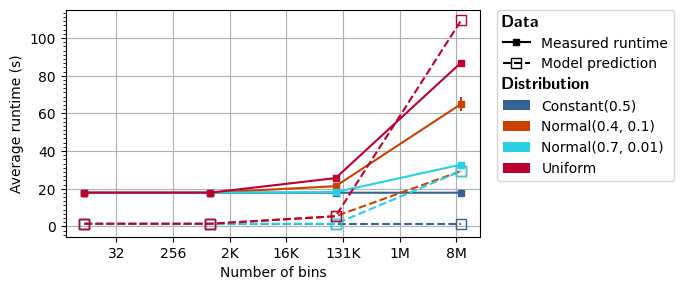

In [17]:
save = True
figname = f"{cpu_output_folder}/cpu_addbincontent_validation.pdf"

selected_env = "CPU"
selected_bulksize = 32768
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

# Legend Labels
plot_validation_labels()

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        selected_nvals,
        unique_nbins,
        selected_bulksize,
        selected_edges,
    )
    avg = cpu_gp_ivd.mean().loc[arg]
    std = cpu_gp_ivd.std().loc[arg]

    p = ax.errorbar(unique_nbins, avg["tfill"], yerr=std["tfill"], **bm_style)

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    subsize = get_subsize(distr, unique_nbins)
    pred = (
        T_cpu_fill(unique_nbins, subsize)
        * selected_nvals
        * unit_to_unit_factor("ns", "s")
    )
    ax.errorbar(unique_nbins, pred, c=p[0].get_color(), **pred_nocolor_style)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.665),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Average runtime (s)")
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

# Update Stats

## Design

In [18]:
#

## Calibration

In [19]:
cpu_usb_df = cpu_bm_df[cpu_bm_df["func_name"] == "UpdateStats"].copy()
cpu_usb_mean = cpu_usb_df.loc[cpu_usb_df["name"].str.contains("mean")]
cpu_usb_std = cpu_usb_df.loc[cpu_usb_df["name"].str.contains("stddev")]
cpu_usb_mean

,name,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,bin,nbins,val,aggregate_name,aggregate_unit,dim,func_name
920,BM_UpdateStats/1/manual_time_mean,BM_UpdateStats/1/manual_time,aggregate,1000000.0,NaN,1,3,19.433894,59.033994,ms,NaN,NaN,NaN,mean,time,1.0,UpdateStats


In [20]:
T_cpu_updatestats = (
    cpu_usb_mean.loc[cpu_usb_mean["dim"] == 1]["real_time"]
    * unit_to_unit_factor(cpu_usb_mean["time_unit"].values[0], "ns")
    / cpu_usb_mean["repetitions"].values[0]
).values[0]
T_cpu_updatestats

19.433893555676768

## Validation

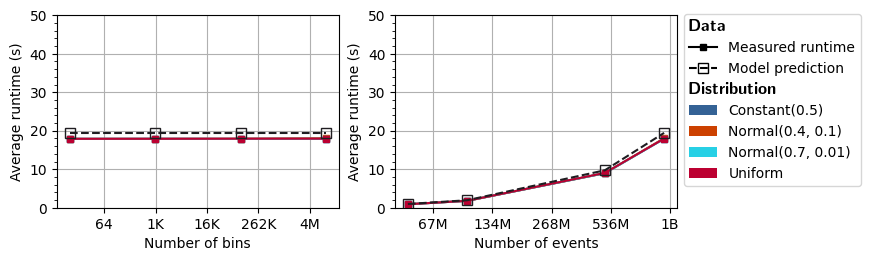

In [21]:
save = True
figname = f"{cpu_output_folder}/cpu_updatestats_validation.pdf"

selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False

fig = plt.figure(figsize=(8, 2.5))
ax = plt.subplot(121)

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        selected_nvals,
        unique_nbins,
        selected_bulksize,
        selected_edges,
    )
    avg = cpu_gp_ivd.mean().loc[arg]
    std = cpu_gp_ivd.std().loc[arg]

    p = ax.errorbar(
        unique_nbins,
        avg["tstats"],
        yerr=std["tstats"],
        **bm_style,
    )

# print(distr)
pred = np.repeat(
    T_cpu_updatestats * selected_nvals * unit_to_unit_factor("ns", "s"),
    len(unique_nbins),
)
ax.errorbar(
    unique_nbins,
    pred,
    c=pred_color,
    marker="s",
    markerfacecolor="none",
    ls="--",
    markersize=7,
)
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, 50])
plt.ylabel("Average runtime (s)")

###############

ax = plt.subplot(122)
plot_validation_labels()

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        unique_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    avg = cpu_gp_ivd.mean().loc[arg]
    std = cpu_gp_ivd.std().loc[arg]

    p = ax.errorbar(
        unique_nvals,
        avg["tstats"],
        yerr=std["tstats"],
        **bm_style,
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

pred = T_cpu_updatestats * unique_nvals * unit_to_unit_factor("ns", "s")
ax.errorbar(
    unique_nvals,
    pred,
    c=pred_color,
    **pred_nocolor_style,
)
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)

plt.xlabel("Number of events")
plt.ylabel("Average runtime (s)")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylim([0, 50])

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.9, 0.54),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

# Total Validation

## Total vs. inner timings

In [22]:
unique_bulksize

array([1.00000000e+00, 8.00000000e+00, 6.40000000e+01, 5.12000000e+02,
       4.09600000e+03, 3.27680000e+04, 2.62144000e+05, 8.19200000e+03,
       1.63840000e+04, 6.55360000e+04, 1.31072000e+05, 2.09715200e+06,
       1.67772160e+07, 1.34217728e+08])

In [23]:
inner_cpu_validation_df["bulksize"].unique()

array([     1,      8,     64,    512,   4096,  32768, 262144])

In [24]:
ivd_unique_bulksize = np.array(
    [v for v in unique_bulksize if v in inner_cpu_validation_df["bulksize"].unique()]
)
ivd_unique_bulksize

array([1.00000e+00, 8.00000e+00, 6.40000e+01, 5.12000e+02, 4.09600e+03,
       3.27680e+04, 2.62144e+05])

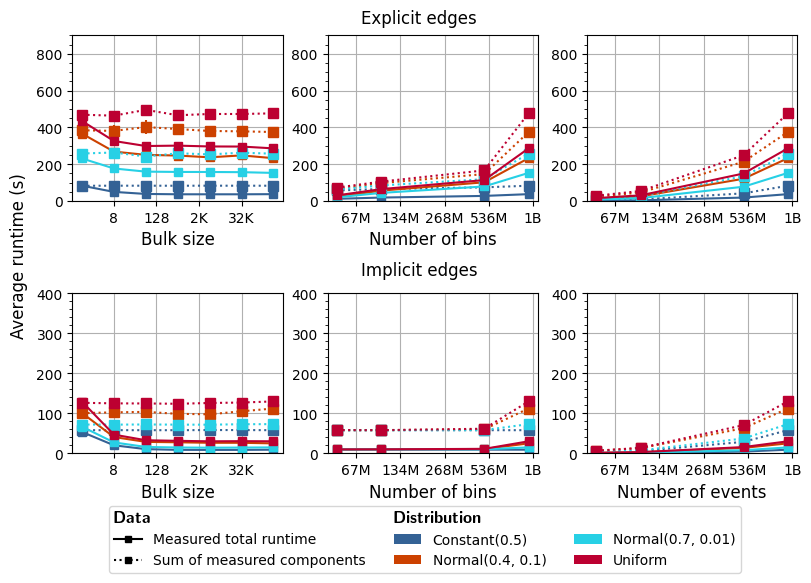

In [25]:
save = True
figname = f"{cpu_output_folder}/cpu_total_vs_inner.pdf"
selected_env = "CPU"
selected_bulksize = 262144
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution

# fig = plt.figure(figsize=(8, 5))
fig = plt.figure(constrained_layout=True, figsize=(8, 5))
(subfig1, subfig2) = fig.subfigures(2, 1)  # create 2x1 subfigures
(ax1, ax2, ax3) = subfig1.subplots(1, 3)  # create 1x2 subplots on subfig1
(ax4, ax5, ax6) = subfig2.subplots(1, 3)  # create 1x2 subplots on subfig2
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

hmax = 900
for edi, edg in enumerate([True, False]):
    ax = axes[edi * 3]
    for di, distr in enumerate(selected_distr):
        arg = (
            selected_env,
            distr,
            selected_nvals,
            selected_nbins,
            ivd_unique_bulksize,
            edg,
        )
        ttotal_avg = cpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = cpu_gp_vd.std().loc[arg]["ttotal"]
        p = ax.errorbar(
            ivd_unique_bulksize,
            ttotal_avg,
            yerr=ttotal_std,
            marker="s",
            ecolor="k",
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )
        tfill_avg = cpu_gp_ivd.mean().loc[arg]["tfill"]
        tfill_std = cpu_gp_ivd.std().loc[arg]["tfill"]
        tusb_avg = cpu_gp_ivd.mean().loc[arg]["tstats"]
        tcpu_usb_std = cpu_gp_ivd.std().loc[arg]["tstats"]
        tfindbin_avg = cpu_gp_ivd.mean().loc[arg]["tfindbin"]
        tfindbin_std = cpu_gp_ivd.std().loc[arg]["tfindbin"]
        p = ax.errorbar(
            ivd_unique_bulksize,
            tfill_avg + tusb_avg + tfindbin_avg,
            yerr=tfill_std + tcpu_usb_std + tfindbin_std,
            color=p[0].get_color(),
            **sum_style,
        )

    ax.set_xlabel("Bulk size", fontsize=12)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    ax.set_ylim([0, hmax - (not edg) * 500])
    # plt.ylabel("Average runtime (s)")

    ###########
    ax = axes[edi * 3 + 1]
    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, edg
        ttotal_avg = cpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = cpu_gp_vd.std().loc[arg]["ttotal"]
        p = ax.errorbar(
            unique_nvals,
            ttotal_avg,
            yerr=ttotal_std,
            marker="s",
            ecolor="k",
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )
        tfill_avg = cpu_gp_ivd.mean().loc[arg]["tfill"]
        tfill_std = cpu_gp_ivd.std().loc[arg]["tfill"]
        tusb_avg = cpu_gp_ivd.mean().loc[arg]["tstats"]
        tcpu_usb_std = cpu_gp_ivd.std().loc[arg]["tstats"]
        tfindbin_avg = cpu_gp_ivd.mean().loc[arg]["tfindbin"]
        tfindbin_std = cpu_gp_ivd.std().loc[arg]["tfindbin"]
        p = ax.errorbar(
            unique_nvals,
            tfill_avg + tusb_avg + tfindbin_avg,
            yerr=tfill_std + tcpu_usb_std + tfindbin_std,
            color=p[0].get_color(),
            **sum_style,
        )

    ax.set_xlabel("Number of bins", fontsize=12)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    # plt.ylim([0, 50])
    ax.set_ylim([0, hmax - (not edg) * 500])
    # plt.ylabel("Average runtime (s)")

    ###########
    ax = axes[edi * 3 + 2]
    ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
    ax.plot(
        0,
        0,
        label="Sum of measured components",
        c="k",
        marker="s",
        ls=":",
        markersize=5,
    )
    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = cpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = cpu_gp_vd.std().loc[arg]["ttotal"]
        p = ax.errorbar(
            unique_nvals,
            ttotal_avg,
            yerr=ttotal_std,
            marker="s",
            ecolor="k",
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        tfill_avg = cpu_gp_ivd.mean().loc[arg]["tfill"]
        tfill_std = cpu_gp_ivd.std().loc[arg]["tfill"]
        tusb_avg = cpu_gp_ivd.mean().loc[arg]["tstats"]
        tcpu_usb_std = cpu_gp_ivd.std().loc[arg]["tstats"]
        tfindbin_avg = cpu_gp_ivd.mean().loc[arg]["tfindbin"]
        tfindbin_std = cpu_gp_ivd.std().loc[arg]["tfindbin"]
        p = ax.errorbar(
            unique_nvals,
            tfill_avg + tusb_avg + tfindbin_avg,
            yerr=tfill_std + tcpu_usb_std + tfindbin_std,
            color=p[0].get_color(),
            **sum_style,
        )
        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xlabel("Number of events", fontsize=12)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )

    ax.set_ylim([0, hmax - (not edg) * 500])

# ax = plt.subplot(221)
subfig1.suptitle("Explicit edges", fontsize=12)
subfig2.suptitle("Implicit edges", fontsize=12)
# ax = plt.subplot(223)
# fig.subplots_adjust(wspace=0.2, hspace=0.5)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    bbox_to_anchor=(0.12, -0.15),
    ncols=3,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

fig.supylabel("Average runtime (s)")
# plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

plt.show()

## Runtime

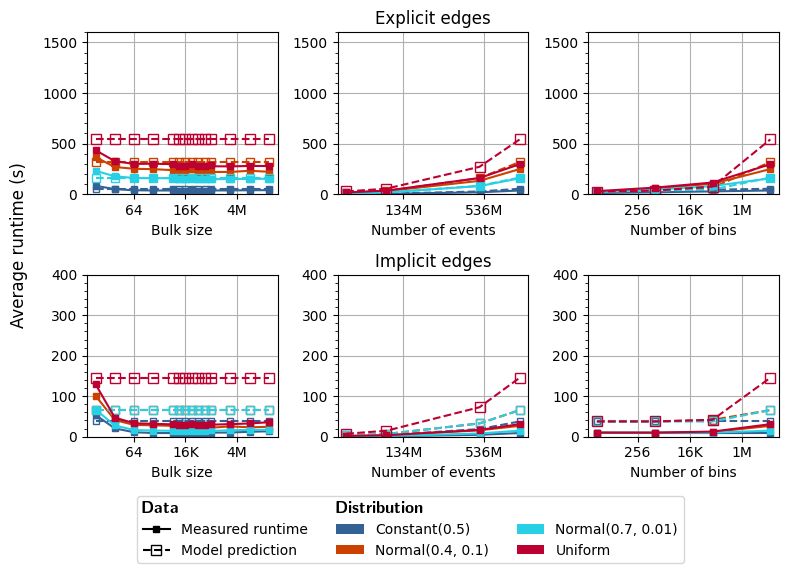

In [26]:
save = True
figname = f"{cpu_output_folder}/cpu_cpu_validation_das6.pdf"
selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
# selected_distr = [
#                     "normal-0.4-0.1",
#                   "uniform"
#                  ]
edg = True

fig = plt.figure(figsize=(8, 5))
hmax_exp = 1600
hdifd_imp = 1200

def ms(di):
    return 1.2 * di + 4

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi * 3 + 1)

    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, selected_nvals, selected_nbins, unique_bulksize, edg
        ttotal_avg = cpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = cpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_bulksize, ttotal_avg, yerr=ttotal_std, **bm_style)

        # Predicition in nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_cpu_fill(selected_nbins, subsize)
        tfindbin_pred = T_cpu_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_cpu_updatestats
        pred = np.repeat(
            (tfill_pred + tusb_pred + tfindbin_pred)
            * selected_nvals
            * unit_to_unit_factor("ns", "s"),
            len(unique_bulksize),
        )
        plt.errorbar(
            unique_bulksize,
            pred,
            color=p[0].get_color(),
            **{**pred_nocolor_style, "markersize": ms(di)},
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Bulk size")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 2)

    # Legend Labels
    ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
    plt.plot(
        0,
        0,
        label="Model prediction",
        c="k",
        marker="s",
        markersize=7,
        markerfacecolor="none",
    )
    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = cpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = cpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, **bm_style)

        # In nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_cpu_fill(selected_nbins, subsize)
        tfindbin_pred = T_cpu_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_cpu_updatestats
        pred = (
            (tfill_pred + tusb_pred + tfindbin_pred)
            * unique_nvals
            * unit_to_unit_factor("ns", "s")
        )
        plt.errorbar(
            unique_nvals,
            pred,
            color=p[0].get_color(),
            **{**pred_nocolor_style, "markersize": ms(di)},
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of events")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 3)

    # Legend Labels
    plot_validation_labels()

    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, edg
        ttotal_avg = cpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = cpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nbins, ttotal_avg, yerr=ttotal_std, **bm_style)

        # In nanoseconds!
        subsize = get_subsize(distr, unique_nbins)
        tfill_pred = T_cpu_fill(unique_nbins, subsize)
        tfindbin_pred = T_cpu_findbin(edg, unique_nbins, subsize)
        tusb_pred = T_cpu_updatestats
        pred = (
            (tfill_pred + tusb_pred + tfindbin_pred)
            * selected_nvals
            * unit_to_unit_factor("ns", "s")
        )
        plt.errorbar(
            unique_nbins,
            pred,
            color=p[0].get_color(),
            **{**pred_nocolor_style, "markersize": ms(di)},
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of bins")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    bbox_to_anchor=(0.17, -0.15),
    ncols=3,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

# plt.legend()
fig.supylabel("Average runtime (s)")

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")